## Project Math Foundation of Machine Learning
## Gabriel Perez - 197419
## Paper Implementation: 
### Enhancing Resolution of Digital Rock Images with Super Resolution Convolutional Neural Networks.

You can find the original paper in the following link:
https://www.sciencedirect.com/science/article/pii/S0920410519306825

In this notebook we reproduce the implementation of Super Resolution Convolutional Neural Networks for carbonate rocks.

In [99]:
# import libraries

%load_ext autoreload
%autoreload 2
%matplotlib inline
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.notebook import tqdm
from torchinfo import summary
import torch.nn.functional as F
import math

from torchvision import transforms
from PIL import Image

from utils import *
from models import *
from train import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
set_seed(100)
device = set_device()

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA A100-SXM4-80GB


The data can be found in the Digital Rocks website: https://www.digitalrocksportal.org/projects/211

In [3]:
train_lowres_lst = sorted(os.listdir('carbonate2D_train_LR_unknown_X4'))
train_highres_lst = sorted(os.listdir('carbonate2D_train_HR'))

test_lowres_lst = sorted(os.listdir('carbonate2D_valid_LR_unknown_X4'))
test_highres_lst = sorted(os.listdir('carbonate2D_valid_HR'))

# get data from folders 
X = stack_images('carbonate2D_train_LR_unknown_X4', train_lowres_lst)
y = stack_images('carbonate2D_train_HR', train_highres_lst, res = 'high')

# get data from folders 
X_test = stack_images('carbonate2D_valid_LR_unknown_X4', test_lowres_lst)
y_test = stack_images('carbonate2D_valid_HR', test_highres_lst, res = 'high')

In [4]:
X.shape, X_test.shape

(torch.Size([800, 1, 200, 200]), torch.Size([100, 1, 200, 200]))

In [5]:
# Create Datasets and Dataloaders
batch_size = 32
train_dataset = TensorDataset(X, y)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
#Initialize early stopping object   
early_stopping = EarlyStopping(patience=50, min_delta=0.0001) # a mas grande el min delta va correr por mas tiempo
model_path = "best_model.pth"

In [6]:
# Instantiate the model
model_SRCNN = SRResNet().to(device)
# Define the reconstruction loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model_SRCNN.parameters(), lr=0.001)
num_epochs = 100

In [8]:
# Train the SRCNN model
losses, psnr_train, losses_test, psnr_test = train_model(model_SRCNN, criterion, optimizer, num_epochs, train_dataloader, test_dataloader, early_stopping, model_path, device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0569, Train PSNR: 18.258, Test loss: 0.0443, Test PSNR: 12.7299
Epoch: 5, Train loss: 0.0097, Train PSNR: 20.2121, Test loss: 0.0088, Test PSNR: 19.8502
Epoch: 10, Train loss: 0.0094, Train PSNR: 20.2114, Test loss: 0.0082, Test PSNR: 20.124
Epoch: 15, Train loss: 0.0082, Train PSNR: 20.9486, Test loss: 0.0074, Test PSNR: 21.3917
Epoch: 20, Train loss: 0.0084, Train PSNR: 20.8713, Test loss: 0.0071, Test PSNR: 20.7352
Epoch: 25, Train loss: 0.0072, Train PSNR: 21.5421, Test loss: 0.0066, Test PSNR: 21.8904
Epoch: 30, Train loss: 0.0071, Train PSNR: 20.3418, Test loss: 0.0069, Test PSNR: 21.52
Epoch: 35, Train loss: 0.0066, Train PSNR: 21.3105, Test loss: 0.0068, Test PSNR: 21.1048
Epoch: 40, Train loss: 0.0064, Train PSNR: 22.0092, Test loss: 0.0059, Test PSNR: 21.5606
Epoch: 45, Train loss: 0.0068, Train PSNR: 21.9047, Test loss: 0.0057, Test PSNR: 22.521
Epoch: 50, Train loss: 0.0058, Train PSNR: 22.3713, Test loss: 0.0055, Test PSNR: 22.6826
Epoch: 55, Train 

In [7]:
# Run this cell to load pretrained weights to the model
state_dict = torch.load('best_model.pth')
model_SRCNN.load_state_dict(state_dict)

<All keys matched successfully>

In [64]:
set_seed(100)
model_SRCNN_output, model_SRCNN_high_res, model_SRCNN_low_res = evaluate_model(model_SRCNN, test_dataloader, device)

In [12]:
# load the Train of the SRCNN model
losses, psnr_train, losses_test, psnr_test = np.load('lst_history_SRCNN.npy')

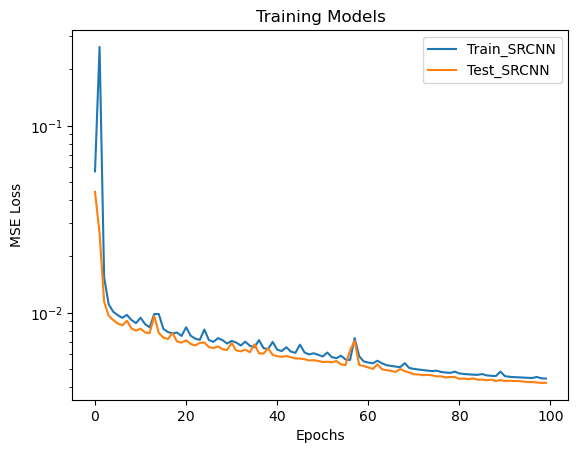

In [14]:
plt.semilogy(losses, label = 'Train_SRCNN') 
plt.semilogy(losses_test, label = 'Test_SRCNN')
plt.title('Training Models')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

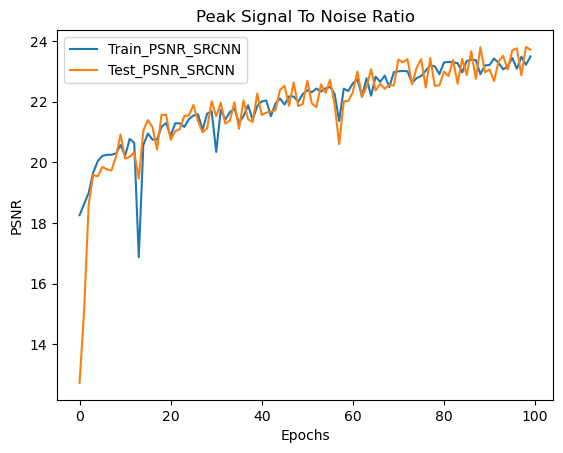

In [15]:
plt.plot(psnr_train, label = 'Train_PSNR_SRCNN')
plt.plot(psnr_test, label = 'Test_PSNR_SRCNN')
plt.title('Peak Signal To Noise Ratio')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

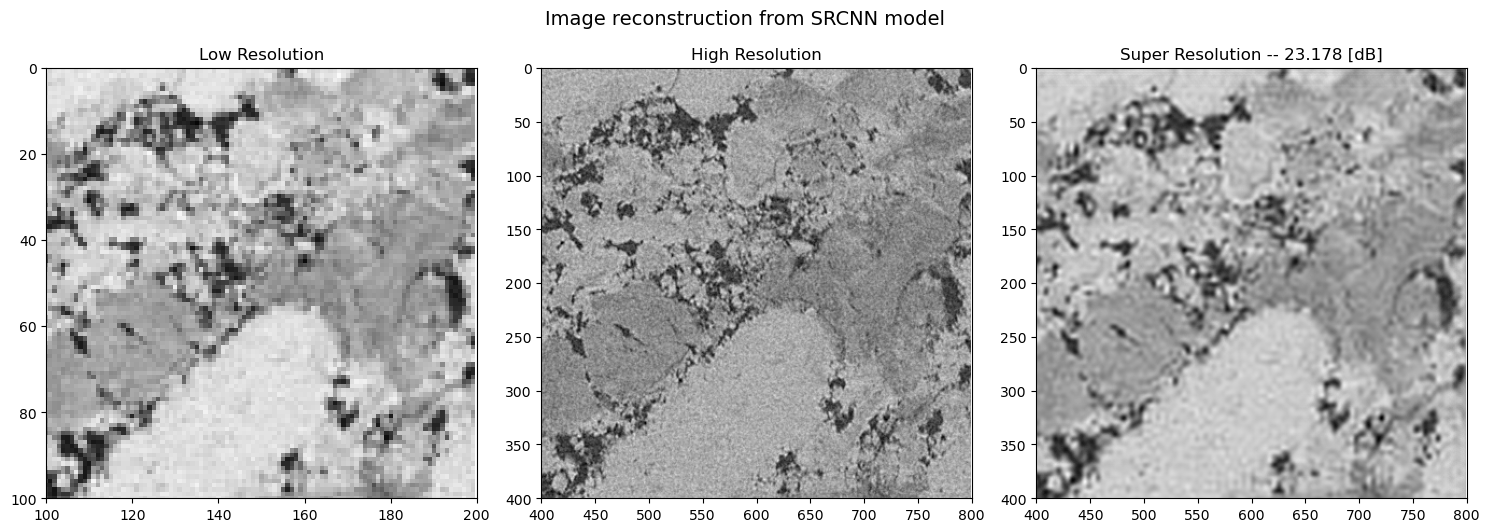

In [78]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(model_SRCNN_low_res[1][0].detach().cpu().numpy(), cmap = 'gray')
ax[0].set(xlim=(100, 200), ylim=(100, 0))
ax[0].set_title('Low Resolution')
ax[1].imshow(model_SRCNN_high_res[1][0].detach().cpu().numpy(), cmap = 'gray')
ax[1].set(xlim=(400, 800), ylim=(400, 0))
ax[1].set_title('High Resolution')
ax[2].imshow(model_SRCNN_output[1][0].detach().cpu().numpy(), cmap = 'gray')
ax[2].set(xlim=(400, 800), ylim=(400, 0))
psnr_im = PSNR_metric(model_SRCNN_output[1].to(device), model_SRCNN_high_res[1].to(device), device).detach().cpu().numpy().item()
ax[2].set_title(f'Super Resolution -- {round(psnr_im,3)} [dB]')
plt.tight_layout()
plt.suptitle('Image reconstruction from SRCNN model', fontsize = 14, y = 1.05)
plt.show()

In [14]:
lst_history_SRCNN = np.array([losses, psnr_train, losses_test, psnr_test])
np.save('lst_history_SRCNN.npy', lst_history_SRCNN)

In [17]:
# Instantiate the model
model_EDSR = EDSR().to(device)
# Define the reconstruction loss function
criterion = nn.MSELoss()
# Optimizer
optimizer_EDSR = optim.Adam(model_EDSR.parameters(), lr=0.001)

In [16]:
#Initialize early stopping object
model_path_EDSR = "EDSR_best_model.pth"

In [17]:
# Train the EDSR model
losses_EDSR, psnr_train_EDSR, losses_test_EDSR, psnr_test_EDSR = train_model(model_EDSR, criterion, optimizer_EDSR, num_epochs, train_dataloader, test_dataloader, early_stopping, model_path_EDSR, device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.1229, Train PSNR: 18.4776, Test loss: 0.0103, Test PSNR: 19.3499
Epoch: 5, Train loss: 0.0066, Train PSNR: 21.4532, Test loss: 0.0059, Test PSNR: 21.4311
Epoch: 10, Train loss: 0.0054, Train PSNR: 22.4715, Test loss: 0.0051, Test PSNR: 22.0156
Epoch: 15, Train loss: 0.0046, Train PSNR: 23.3804, Test loss: 0.0044, Test PSNR: 23.548
Epoch: 20, Train loss: 0.0044, Train PSNR: 23.5729, Test loss: 0.0042, Test PSNR: 23.6899
Epoch: 25, Train loss: 0.0044, Train PSNR: 23.1628, Test loss: 0.0041, Test PSNR: 23.7852
Epoch: 30, Train loss: 0.0043, Train PSNR: 23.6284, Test loss: 0.0041, Test PSNR: 23.8781
Epoch: 35, Train loss: 0.0044, Train PSNR: 23.661, Test loss: 0.0041, Test PSNR: 23.8473
Epoch: 40, Train loss: 0.0043, Train PSNR: 23.396, Test loss: 0.0041, Test PSNR: 23.2748
Epoch: 45, Train loss: 0.0043, Train PSNR: 23.6217, Test loss: 0.0041, Test PSNR: 23.6423
Epoch: 50, Train loss: 0.0043, Train PSNR: 23.4258, Test loss: 0.0041, Test PSNR: 23.4288
Epoch: 55, Trai

In [18]:
# Run this cell to load pretrained weights to the model EDSR
state_dict_1 = torch.load('EDSR_best_model.pth')
model_EDSR.load_state_dict(state_dict_1)

<All keys matched successfully>

In [66]:
set_seed(100)
model_EDSR_output, model_EDSR_high_res, model_EDSR_low_res = evaluate_model(model_EDSR, test_dataloader, device)

In [20]:
# load the Train of the SRCNN model
losses_EDSR, psnr_train_EDSR, losses_test_EDSR, psnr_test_EDSR = np.load('lst_history_EDSR.npy')

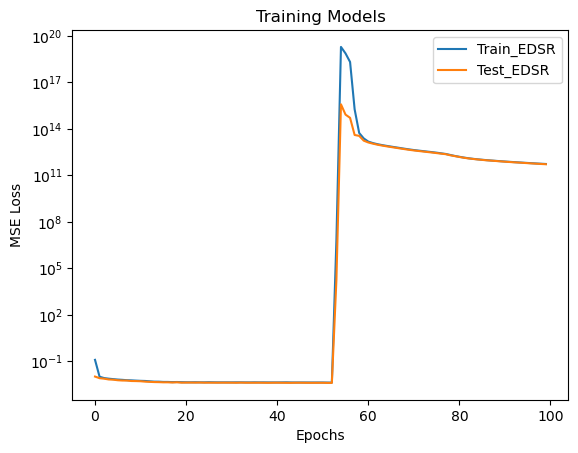

In [21]:
plt.semilogy(losses_EDSR, label = 'Train_EDSR') 
plt.semilogy(losses_test_EDSR, label = 'Test_EDSR')
plt.title('Training Models')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

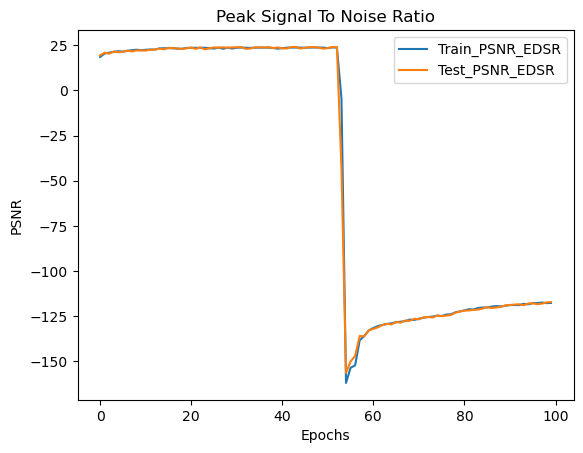

In [22]:
plt.plot(psnr_train_EDSR, label = 'Train_PSNR_EDSR')
plt.plot(psnr_test_EDSR, label = 'Test_PSNR_EDSR')
plt.title('Peak Signal To Noise Ratio')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

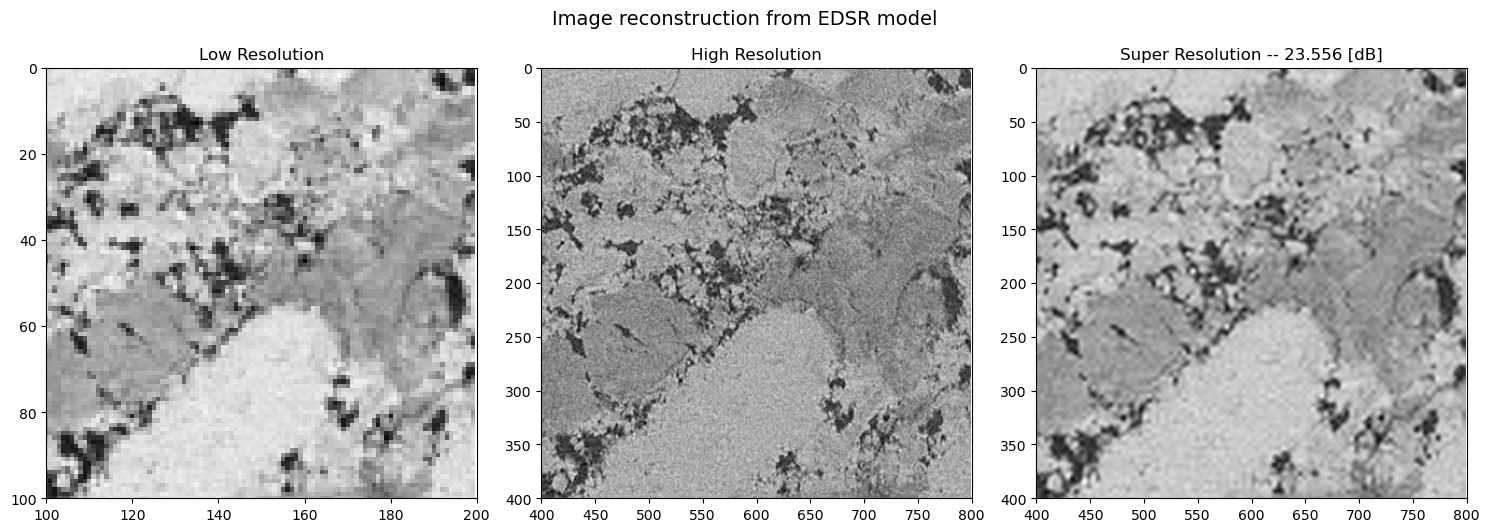

In [77]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(model_EDSR_low_res[1][0].detach().cpu().numpy(), cmap = 'gray')
ax[0].set(xlim=(100, 200), ylim=(100, 0))
ax[0].set_title('Low Resolution')
ax[1].imshow(model_EDSR_high_res[1][0].detach().cpu().numpy(), cmap = 'gray')
ax[1].set(xlim=(400, 800), ylim=(400, 0))
ax[1].set_title('High Resolution')
ax[2].imshow(model_EDSR_output[1][0].detach().cpu().numpy(), cmap = 'gray')
ax[2].set(xlim=(400, 800), ylim=(400, 0))
psnr_im = PSNR_metric(model_EDSR_output[1].to(device), model_EDSR_high_res[1].to(device), device).detach().cpu().numpy().item()
ax[2].set_title(f'Super Resolution -- {round(psnr_im,3)} [dB]')
plt.tight_layout()
plt.suptitle('Image reconstruction from EDSR model', fontsize = 14, y = 1.05)
plt.show()

In [22]:
lst_history_EDSR = np.array([losses_EDSR, psnr_train_EDSR, losses_test_EDSR, psnr_test_EDSR])
np.save('lst_history_EDSR.npy', lst_history_EDSR)

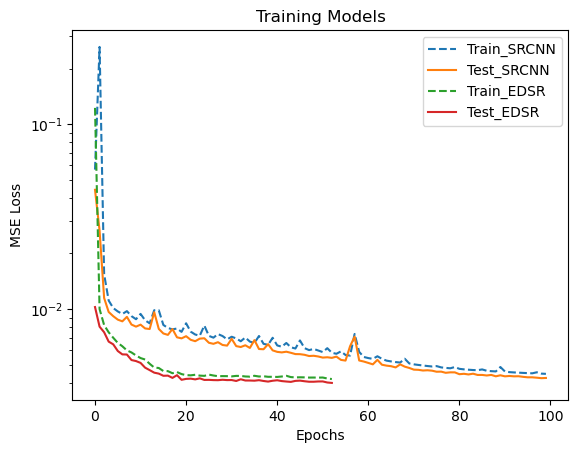

In [108]:
plt.semilogy(losses, linestyle = '--', label = 'Train_SRCNN') 
plt.semilogy(losses_test, label = 'Test_SRCNN')
plt.semilogy(losses_EDSR[:53], linestyle = '--',label = 'Train_EDSR') 
plt.semilogy(losses_test_EDSR[:53], label = 'Test_EDSR')
plt.title('Training Models')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

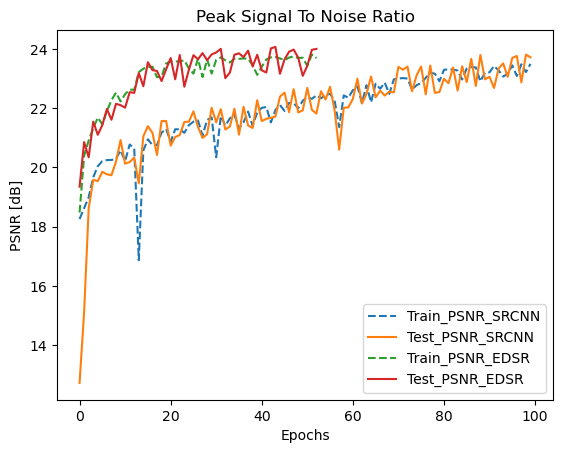

In [109]:
plt.plot(psnr_train, linestyle = '--', label = 'Train_PSNR_SRCNN')
plt.plot(psnr_test, label = 'Test_PSNR_SRCNN')
plt.plot(psnr_train_EDSR[:53], linestyle = '--', label = 'Train_PSNR_EDSR')
plt.plot(psnr_test_EDSR[:53], label = 'Test_PSNR_EDSR')
plt.title('Peak Signal To Noise Ratio')
plt.xlabel('Epochs')
plt.ylabel('PSNR [dB]')
plt.legend()
plt.show()

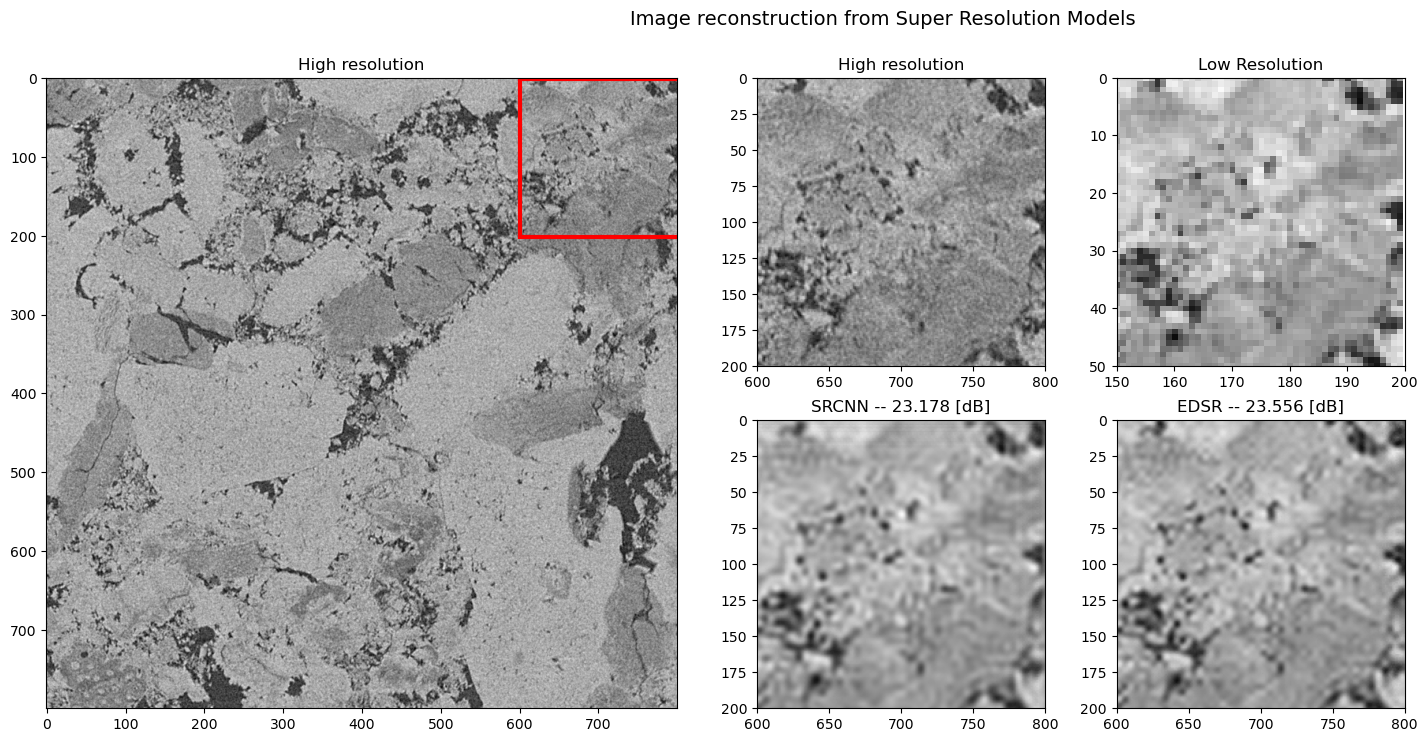

In [107]:
fig = plt.figure(figsize=(18, 7))

ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2, 5), (0, 2))
ax3 = plt.subplot2grid((2, 5), (0, 3))
ax4 = plt.subplot2grid((2, 5), (1, 2))
ax5 = plt.subplot2grid((2, 5), (1, 3))

ax1.imshow(model_EDSR_high_res[1][0].detach().cpu().numpy(), cmap = 'gray')
ax1.set_title("High resolution")
rect = patches.Rectangle((600, 1), 795, 200, linewidth=3, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax2.imshow(model_EDSR_high_res[1][0].detach().cpu().numpy(), cmap = 'gray')
ax2.set(xlim=(600, 800), ylim=(200, 0))
ax2.set_title("High resolution")
ax3.imshow(model_EDSR_low_res[1][0].detach().cpu().numpy(), cmap = 'gray')
ax3.set(xlim=(150, 200), ylim=(50, 0))
ax3.set_title('Low Resolution')
psnr_im_0 = PSNR_metric(model_SRCNN_output[1].to(device), model_SRCNN_high_res[1].to(device), device).detach().cpu().numpy().item()
ax4.imshow(model_SRCNN_output[1][0].detach().cpu().numpy(), cmap = 'gray')
ax4.set(xlim=(600, 800), ylim=(200, 0))
ax4.set_title(f'SRCNN -- {round(psnr_im_0,3)} [dB]')
psnr_im_1 = PSNR_metric(model_EDSR_output[1].to(device), model_EDSR_high_res[1].to(device), device).detach().cpu().numpy().item()
ax5.imshow(model_EDSR_output[1][0].detach().cpu().numpy(), cmap = 'gray')
ax5.set(xlim=(600, 800), ylim=(200, 0))
ax5.set_title(f'EDSR -- {round(psnr_im_1,3)} [dB]')
plt.suptitle('Image reconstruction from Super Resolution Models', fontsize = 14, y = 1.05)
plt.tight_layout()
plt.show()


In [110]:
summary(model_SRCNN)

Layer (type:depth-idx)                        Param #
SRResNet                                      --
├─ConvolutionalBlock: 1-1                     --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       5,248
│    │    └─PReLU: 3-2                        1
├─Sequential: 1-2                             --
│    └─ResidualBlock: 2-2                     --
│    │    └─ConvolutionalBlock: 3-3           37,057
│    │    └─ConvolutionalBlock: 3-4           37,056
│    └─ResidualBlock: 2-3                     --
│    │    └─ConvolutionalBlock: 3-5           37,057
│    │    └─ConvolutionalBlock: 3-6           37,056
│    └─ResidualBlock: 2-4                     --
│    │    └─ConvolutionalBlock: 3-7           37,057
│    │    └─ConvolutionalBlock: 3-8           37,056
│    └─ResidualBlock: 2-5                     --
│    │    └─ConvolutionalBlock: 3-9           37,057
│    │    └─ConvolutionalBlock: 3-10          37,056
│    └─ResidualBlock: 2-6     

In [111]:
summary(model_EDSR)

Layer (type:depth-idx)                        Param #
EDSR                                          --
├─ConvolutionalBlock: 1-1                     --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       5,248
├─Sequential: 1-2                             --
│    └─ResidualBlock_EDSR: 2-2                --
│    │    └─ConvolutionalBlock: 3-2           36,928
│    │    └─ConvolutionalBlock: 3-3           36,928
│    └─ResidualBlock_EDSR: 2-3                --
│    │    └─ConvolutionalBlock: 3-4           36,928
│    │    └─ConvolutionalBlock: 3-5           36,928
│    └─ResidualBlock_EDSR: 2-4                --
│    │    └─ConvolutionalBlock: 3-6           36,928
│    │    └─ConvolutionalBlock: 3-7           36,928
│    └─ResidualBlock_EDSR: 2-5                --
│    │    └─ConvolutionalBlock: 3-8           36,928
│    │    └─ConvolutionalBlock: 3-9           36,928
│    └─ResidualBlock_EDSR: 2-6                --
│    │    └─ConvolutionalBloc